Hypothesis 5: "The labor force participation rate (LNU02300000) decreases during economic recessions and increases during periods of economic recovery."
Rationale: During recessions, people might drop out of the labor force due to discouragement, and return during recoveries.


In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='fred-employment-initial-test')

# Your query string
query = """
SELECT *
FROM `fred-employment-initial-test.fred_data.fred_data_withnotes`
WHERE series_id IN ('LNU02300000')
"""

# Run the query
query_job = client.query(query)

# Convert the query results to a pandas DataFrame
data = query_job.to_dataframe()

# Display the first few rows
print(data.head())

                       date    series_id  value                        title  \
0 1948-01-01 00:00:00+00:00  LNU02300000   54.9  Employment-Population Ratio   
1 1948-02-01 00:00:00+00:00  LNU02300000   55.0  Employment-Population Ratio   
2 1948-03-01 00:00:00+00:00  LNU02300000   55.1  Employment-Population Ratio   
3 1948-04-01 00:00:00+00:00  LNU02300000   55.9  Employment-Population Ratio   
4 1948-05-01 00:00:00+00:00  LNU02300000   56.1  Employment-Population Ratio   

     units frequency      seasonal_adjustment            last_updated  \
0  Percent   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
1  Percent   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
2  Percent   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
3  Percent   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
4  Percent   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   

                                               notes  
0  The series comes from 

**DEFINING RECESSION PERIODS AND DEFINING THEM IN THE DATA:**

In [ ]:
import pandas as pd

# Define recession periods as tuples of (start, end)
recession_periods = [
    ('1948-11-01', '1949-10-31'),
    ('1953-07-01', '1954-05-31'),
    ('1957-08-01', '1958-04-30'),
    ('1960-04-01', '1961-02-28'),
    ('1969-12-01', '1970-11-30'),
    ('1973-11-01', '1975-03-31'),
    ('1980-01-01', '1980-07-31'),
    ('1981-07-01', '1982-11-30'),
    ('1990-07-01', '1991-03-31'),
    ('2001-03-01', '2001-11-30'),
    ('2007-12-01', '2009-06-30'),
    ('2020-02-01', '2020-04-30')
]

# Convert the recession periods to datetime format
recession_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in recession_periods]

# Ensure 'date' is in datetime format and remove any timezone info
data['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)

# Function to flag recession periods
def is_recession(date, recession_periods):
    for start, end in recession_periods:
        if start <= date <= end:
            return 1
    return 0

# Apply the recession flagging function
data['is_recession'] = data['date'].apply(lambda x: is_recession(x, recession_periods))

# Display the updated data with recession flag
print(data.head())

        date    series_id  value                        title    units  \
0 1948-01-01  LNU02300000   54.9  Employment-Population Ratio  Percent   
1 1948-02-01  LNU02300000   55.0  Employment-Population Ratio  Percent   
2 1948-03-01  LNU02300000   55.1  Employment-Population Ratio  Percent   
3 1948-04-01  LNU02300000   55.9  Employment-Population Ratio  Percent   
4 1948-05-01  LNU02300000   56.1  Employment-Population Ratio  Percent   

  frequency      seasonal_adjustment            last_updated  \
0   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
1   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
2   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
3   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   
4   Monthly  Not Seasonally Adjusted  2024-08-02 07:46:22-05   

                                               notes  is_recession  
0  The series comes from the 'Current Population ...             0  
1  The series comes from the 'Cu

**MEAN VALUES IN RECESSION vs. OUTSIDE RECESSION**

In [ ]:
# Calculate mean values during and outside recessions
mean_values = data.groupby('is_recession')['value'].mean()

# Display the mean values
print(mean_values)

is_recession
0    59.382375
1    58.466176
Name: value, dtype: float64


The mean employment-population ratio is slightly lower during recession periods (is_recession = 1) compared to non-recession periods (is_recession = 0). This aligns with the hypothesis that the labor force participation rate tends to decrease during economic recessions.

**TESTING STATISTICAL SIGNIFICANCE OF DIFFERENCE:**

In [ ]:
from scipy import stats

# Separate the data into two groups: recession and non-recession
recession_data = data[data['is_recession'] == 1]['value']
non_recession_data = data[data['is_recession'] == 0]['value']

# Perform an independent t-test
t_stat, p_value = stats.ttest_ind(recession_data, non_recession_data)

# Display the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: nan
P-value: nan


NaN error - could have missing values, infinite values, similar/indentical values....

In [ ]:
import numpy as np  # Import NumPy

# Check for missing values
print(f"Missing values in recession data: {recession_data.isnull().sum()}")
print(f"Missing values in non-recession data: {non_recession_data.isnull().sum()}")

# Check for infinite values
print(f"Infinite values in recession data: {np.isinf(recession_data).sum()}")
print(f"Infinite values in non-recession data: {np.isinf(non_recession_data).sum()}")

# Check basic statistics
print("Recession Data Statistics:")
print(recession_data.describe())
print("\nNon-Recession Data Statistics:")
print(non_recession_data.describe())

Missing values in recession data: 12
Missing values in non-recession data: 911
Infinite values in recession data: 0
Infinite values in non-recession data: 0
Recession Data Statistics:
count    136.000000
mean      58.466176
std        2.793331
min       51.300000
25%       56.875000
50%       57.900000
75%       59.900000
max       64.200000
Name: value, dtype: float64

Non-Recession Data Statistics:
count    783.000000
mean      59.382375
std        2.748214
min       52.900000
25%       57.200000
50%       59.100000
75%       61.800000
max       64.900000
Name: value, dtype: float64


**REMOVING MISSING VALUES:**

In [ ]:
# Remove missing values from both datasets
recession_data_clean = recession_data.dropna()
non_recession_data_clean = non_recession_data.dropna()

# Perform an independent t-test on the cleaned data
t_stat, p_value = stats.ttest_ind(recession_data_clean, non_recession_data_clean)

# Display the t-statistic and p-value
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: -3.5799431976723155
P-value: 0.000361701702390532


Based on this analysis, we can reject the null hypothesis that there is no difference in labor force participation rates between recession and non-recession periods. The evidence suggests that the labor force participation rate does indeed decrease during economic recessions and increases during periods of economic recovery, supporting your hypothesis.

**RECALCULATING MEAN (SAME RESULT):**

In [ ]:
# Remove missing values from the data
cleaned_data = data.dropna()

# Calculate mean values during and outside recessions on the cleaned data
cleaned_mean_values = cleaned_data.groupby('is_recession')['value'].mean()

# Display the cleaned mean values
print(cleaned_mean_values)

is_recession
0    59.382375
1    58.466176
Name: value, dtype: float64


In [ ]:
from sklearn.metrics import r2_score

# Fit a simple linear regression model for the data
# Assuming 'recession_data_clean' and 'non_recession_data_clean' are defined as before

# Combine the data back into one dataset for regression
combined_data = pd.concat([recession_data_clean, non_recession_data_clean])

# Create labels for recession (1) and non-recession (0)
labels = pd.concat([pd.Series([1] * len(recession_data_clean)), pd.Series([0] * len(non_recession_data_clean))])

# Fit the linear model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(labels.values.reshape(-1, 1), combined_data)

# Calculate the predicted values
predictions = model.predict(labels.values.reshape(-1, 1))

# Calculate the R^2 value
r2 = r2_score(combined_data, predictions)
print(f"R^2 value: {r2}")

R^2 value: 0.013783365086133426


**DASHBOARD:**

<ipython-input-13-0b9a10be6c57>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_recession', y='value', data=data, ax=axs[0, 1], palette=['#00FFFF', '#FF00FF'])


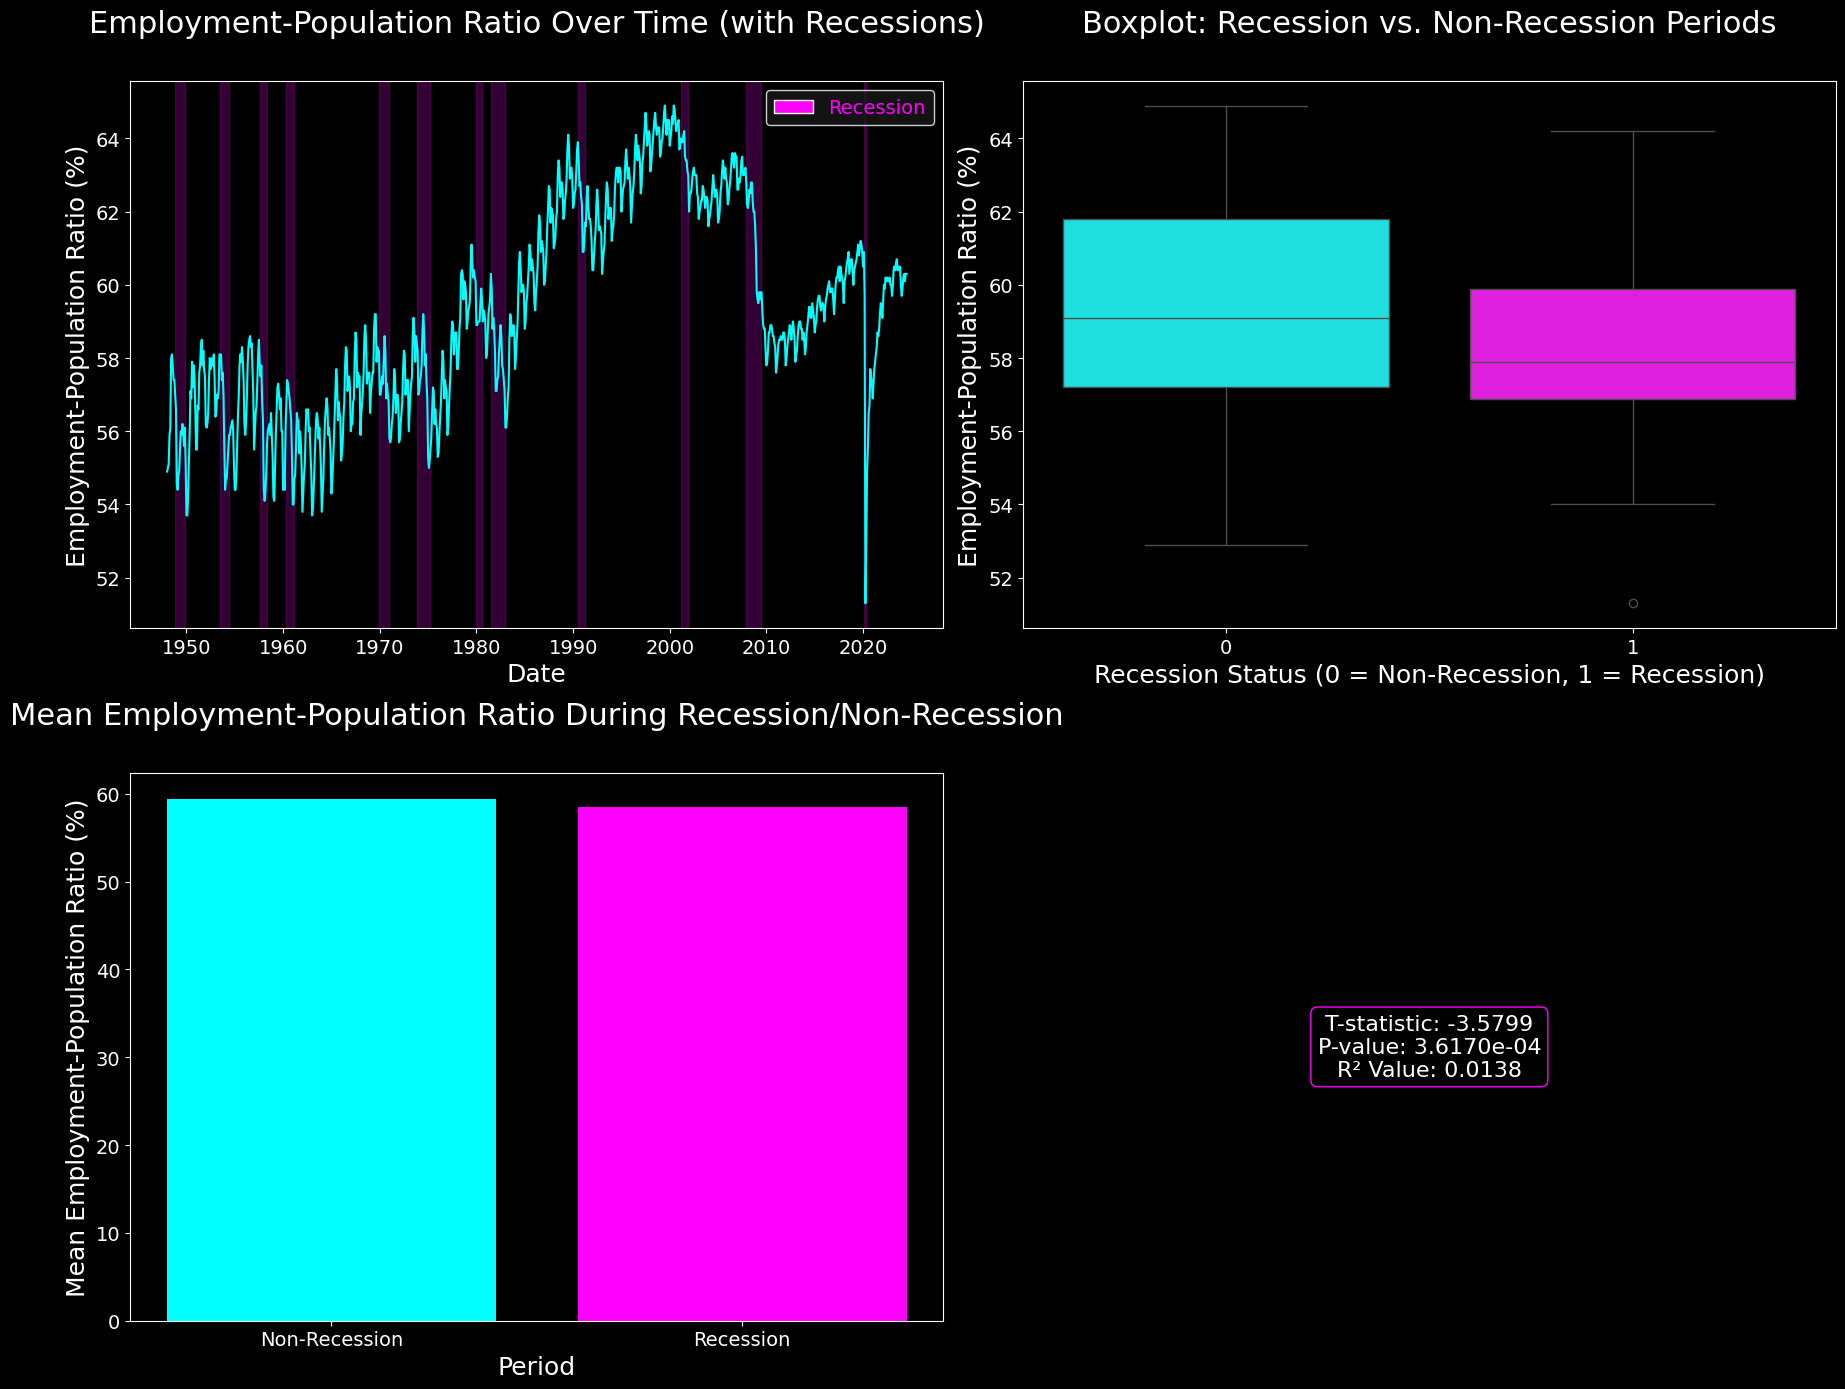

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Create a figure and axes for the dashboard
fig, axs = plt.subplots(2, 2, figsize=(18, 14), facecolor='#000000')
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Plot 1: Time Series Line Plot (with Shaded Recession Periods)
axs[0, 0].plot(data['date'], data['value'], color='#00FFFF', label='Employment-Population Ratio', zorder=3)

# Shade the recession periods
for start, end in recession_periods:
    axs[0, 0].axvspan(start, end, color='#FF00FF', alpha=0.2, label='Recession' if start == recession_periods[0][0] else "")

axs[0, 0].set_facecolor('#000000')
axs[0, 0].set_xlabel('Date', fontsize=18, color='white')
axs[0, 0].set_ylabel('Employment-Population Ratio (%)', fontsize=18, color='white')
axs[0, 0].tick_params(axis='both', labelsize=14, colors='white')
axs[0, 0].spines['left'].set_color('white')
axs[0, 0].spines['bottom'].set_color('white')
axs[0, 0].spines['top'].set_color('white')
axs[0, 0].spines['right'].set_color('white')
axs[0, 0].set_title('Employment-Population Ratio Over Time (with Recessions)', fontsize=22, color='white', pad=35)

legend_elements = [Patch(facecolor='#FF00FF', edgecolor='white', label='Recession')]
axs[0, 0].legend(handles=legend_elements, loc='upper right', fontsize=14, facecolor='#181818', edgecolor='white', labelcolor=['#FF00FF'])

# Plot 2: Boxplot of Recession vs. Non-Recession Periods
sns.boxplot(x='is_recession', y='value', data=data, ax=axs[0, 1], palette=['#00FFFF', '#FF00FF'])
axs[0, 1].set_facecolor('#000000')
axs[0, 1].set_xlabel('Recession Status (0 = Non-Recession, 1 = Recession)', fontsize=18, color='white')
axs[0, 1].set_ylabel('Employment-Population Ratio (%)', fontsize=18, color='white')
axs[0, 1].tick_params(axis='both', labelsize=14, colors='white')
axs[0, 1].spines['left'].set_color('white')
axs[0, 1].spines['bottom'].set_color('white')
axs[0, 1].spines['top'].set_color('white')
axs[0, 1].spines['right'].set_color('white')
axs[0, 1].set_title('Boxplot: Recession vs. Non-Recession Periods', fontsize=22, color='white', pad=35)

# Plot 3: Bar Chart of Mean Values in Recession and Non-Recession
axs[1, 0].bar(['Non-Recession', 'Recession'], mean_values, color=['#00FFFF', '#FF00FF'])
axs[1, 0].set_facecolor('#000000')
axs[1, 0].set_xlabel('Period', fontsize=18, color='white')
axs[1, 0].set_ylabel('Mean Employment-Population Ratio (%)', fontsize=18, color='white')
axs[1, 0].tick_params(axis='both', labelsize=14, colors='white')
axs[1, 0].spines['left'].set_color('white')
axs[1, 0].spines['bottom'].set_color('white')
axs[1, 0].spines['top'].set_color('white')
axs[1, 0].spines['right'].set_color('white')
axs[1, 0].set_title('Mean Employment-Population Ratio During Recession/Non-Recession', fontsize=22, color='white', pad=35)

# Plot 4: T-Test Results and R² Score (as text output)
t_test_text = f"T-statistic: {t_stat:.4f}\nP-value: {p_value:.4e}\nR² Value: {r2:.4f}"
axs[1, 1].text(0.5, 0.5, t_test_text, transform=axs[1, 1].transAxes, fontsize=16, color='white',
               verticalalignment='center', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='#000000', edgecolor='#FF00FF'))
axs[1, 1].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the complete dashboard
plt.show()